In [55]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Arc
import numpy as np
from highlight_text import fig_text
import seaborn as sns
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from mplsoccer import (VerticalPitch, Pitch, create_transparent_cmap,
                       FontManager, arrowhead_marker, Sbopen)
from PIL import Image
import requests
from io import BytesIO
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import image

In [56]:
import requests

params ={
    'matchId':'4519521'
}

response = requests.get('https://www.fotmob.com/api/matchDetails',params=params)
data = response.json()


In [57]:
expected_goals = True

In [58]:
df_score = pd.DataFrame(data['header']['teams'])
#df_score['Badge'] = df_score['name'].apply(lambda x: f"C:/Users/George/Documents/Football Analytics/Team Logos/{x.lower()}_logo.png")
df_score['score'] = df_score['score'].astype(float)

In [59]:
df_score

,name,id,score,imageUrl,pageUrl,fifaRank
0,Coventry City,8669,0.0,https://images.fotmob.com/image_resources/logo...,/teams/8669/overview/coventry-city,None
1,Norwich City,9850,1.0,https://images.fotmob.com/image_resources/logo...,/teams/9850/overview/norwich-city,None


In [60]:
h_team = df_score['name'][0]
a_team = df_score['name'][1]
h_id = df_score['id'][0]
a_id = df_score['id'][1]
h_colour = data['general']['teamColors']['lightMode']['home']
a_colour = data['general']['teamColors']['lightMode']['away']
#h_badge = df_score['Badge'][0]
#a_badge = df_score['Badge'][1]
h_goals = df_score['score'][0]
a_goals = df_score['score'][1]

In [61]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Oxford United":"Oxford","Norwich City":"Norwich","Coventry City":"Coventry","Derby County":"Derby","Crystal Palace":"Palace","Brighton and Hove Albion": "Brighton", "Huddersfield Town":"Huddersfield","Manchester United": "Man Utd", "Newcastle United": "Newcastle", "Nottingham Forest":"Forest","Tottenham Hotspur": "Spurs","Sheffield United":"Sheff Utd", "West Ham United": "West Ham","West Bromwich Albion":"West Brom", "Wolverhampton Wanderers": "Wolves","Wycombe Wanderers":"Wycombe","Sheffield Wednesday":"Sheff Weds","Queens Park Rangers":"QPR","Rotherham United":"Rotherham","Preston North End":"Preston","Peterborough United":"P'borough Utd","Charlton Athletic":"Charlton","Bolton Wanderers":"Bolton","Blackburn Rovers":"Blackburn","Manchester City":"Man City"} 
mapping = MissingDict(**map_values)
h_team = mapping[h_team]
a_team = mapping[a_team]

In [62]:
top_stats = data['content']['stats']['Periods']['All']['stats'][0]['stats']
df_stats = pd.DataFrame(top_stats)

# Create a new DataFrame with the 'stats' column as a list
df_new = pd.DataFrame({'stats': df_stats['stats'].tolist()})

# Convert lists to strings before splitting
df_new['stats'] = df_new['stats'].apply(lambda x: ', '.join(map(str, x)))

# Split the 'stats' column into two columns based on the delimiter ', '
df_new[['home_stats', 'away_stats']] = df_new['stats'].str.split(', ', expand=True)

# Drop the original 'stats' column
df_new = df_new.drop('stats', axis=1)

# Concatenate the new columns with the original DataFrame
df_stats = pd.concat([df_stats, df_new], axis=1)
df_stats = df_stats.drop('stats', axis=1)

In [63]:
if expected_goals == True:
    df_xG = pd.DataFrame(data['content']['stats']['Periods']['All']['stats'][2]['stats'])
    df_xG.drop(0, axis=0, inplace=True)
    df_xG.drop(1, axis=0, inplace=True)
    df_xG.drop(4, axis=0, inplace=True)
    df_xG.drop('key', axis=1, inplace=True)
    df_xG.drop('type', axis=1, inplace=True)
    df_xG.reset_index(drop=True, inplace=True)
# Create a new DataFrame with the 'stats' column as a list
    df_new2 = pd.DataFrame({'stats': df_xG['stats'].tolist()})

# Convert lists to strings before splitting
    df_new2['stats'] = df_new2['stats'].apply(lambda x: ', '.join(map(str, x)))

# Split the 'stats' column into two columns based on the delimiter ', '
    df_new2[['home_stats', 'away_stats']] = df_new2['stats'].str.split(', ', expand=True)

# Drop the original 'stats' column
    df_new2 = df_new2.drop('stats', axis=1)

# Concatenate the new columns with the original DataFrame
    df_xG = pd.concat([df_xG, df_new2], axis=1)
    df_xG = df_xG.drop('stats', axis=1)

    df_xG[['home_stats', 'away_stats']] = df_xG[['home_stats', 'away_stats']].astype(float)

    away_prevented = (df_xG['home_stats'][2] - h_goals).round(2) 
    home_prevented = (df_xG['away_stats'][2] - a_goals).round(2)
    if home_prevented > away_prevented:
        highlight = 'home'
    else:
        highlight = 'away'
    goals_prevented = {'title':'Goals Prevented', 'highlighted': highlight,'home_stats': home_prevented, 'away_stats': away_prevented}

    df_xG.loc[len(df_xG)] = goals_prevented

In [64]:
if expected_goals == True:
    df_top_stats = pd.concat([df_stats, df_xG], axis=0)
    df_top_stats.reset_index(drop=True, inplace=True)
    df_top_stats.drop(7, axis=0, inplace=True)
else:
    df_top_stats = df_stats

df_top_stats.drop('key', axis=1, inplace=True)
df_top_stats.drop('type', axis=1, inplace=True)
df_top_stats_plot = df_top_stats[['home_stats','title','away_stats']]
df_top_stats_plot.rename(columns={'home_stats':h_team,'away_stats':a_team,'title':''}, inplace=True)

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\64951940.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_stats_plot.rename(columns={'home_stats':h_team,'away_stats':a_team,'title':''}, inplace=True)


In [65]:
df_top_stats_plot.loc[df_top_stats_plot[''] == 'Accurate passes', ''] = 'Acc. passes'


In [66]:
df_top_stats_plot

,Coventry,,Norwich
0,44,Ball possession,56
1,0.98,Expected goals (xG),0.35
2,14,Total shots,9
3,5,Shots on target,1
4,2,Big chances,0
5,2,Big chances missed,0
6,342 (82%),Acc. passes,481 (86%)
8,6,Corners,3
9,0.96,xG open play,0.29
10,0.02,xG set play,0.06


In [67]:
bg_colour = "#282828"
text_colour = "#FFFFFF"
plt.rcParams["text.color"] = text_colour
row_colors = {
    "even": "#E2E2E1",
    "odd": "#B3B0B0",
}

col_defs = [
    ColumnDefinition(
        name=h_team,
        textprops={"ha" : "center", "color": h_colour, "weight": "bold"},
        width=1.0,
    ), 
    ColumnDefinition(
        name='',
        textprops={"ha" : "center", 'fontsize': 11},
        width=1.0,
    ),
    ColumnDefinition(
        name=a_team,
        textprops={"ha" : "center", "color": a_colour, "weight": "bold"},
        width=1.0,
    )
]

In [68]:
shotmap = data['content']['shotmap']['shots']
df = pd.DataFrame(shotmap)

if df['period'].nunique() > 4:
    pen = data['header']['status']['reason']['long']
    pen = pen.split('Pen')[-1].strip()
else:
    pen = ''

periods = df['period'].nunique()

df = df[df['period'].isin(['FirstHalf', 'SecondHalf', 'FirstHalfExtra', 'SecondHalfExtra'])]

df.y = df.y * 1.473
df.x = df.x * 0.94

In [69]:
for x in range(len(df)):
    name = np.char.count(df['playerName'][x], ' ') + 1
    if name == 1:
        df['playerName'][x] = df['playerName'][x]
    elif name == 2:
        df['playerName'][x] = df['playerName'][x].split(' ')[1]
    elif name == 3:
        df['playerName'][x] = df['playerName'][x].split(' ')[1] + ' ' + df['playerName'][x].split(' ')[2]

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3626475897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['playerName'][x] = df['playerName'][x].split(' ')[1]
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3626475897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['playerName'][x] = df['playerName'][x].split(' ')[1]
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3626475897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [70]:
df_home = df[df.teamId == df_score['id'][0]].reset_index(drop=True)
df_away = df[df.teamId == df_score['id'][1]].reset_index(drop=True)

In [71]:
df['expectedGoals'].fillna(0, inplace=True)

In [72]:
home_own_goals = []
for x in df_home.index:
    if df_home['isOwnGoal'][x] == True:
        home_own_goals.append(df_home.iloc[x])
        df_home.drop(x, axis=0, inplace=True)
    else:
        pass

away_own_goals = []
for x in df_away.index:
    if df_away['isOwnGoal'][x] == True:
        away_own_goals.append(df_away.iloc[x])
        df_away.drop(x, axis=0, inplace=True)
    else:
        pass

df_home_own_goals = pd.DataFrame(home_own_goals)
df_away_own_goals = pd.DataFrame(away_own_goals)
df_home = pd.concat([df_home, df_away_own_goals], ignore_index=True)
df_away = pd.concat([df_away, df_home_own_goals], ignore_index=True)
df_home = df_home.sort_values(by='min', ascending=True)
df_away = df_away.sort_values(by='min', ascending=True)
df_home.reset_index(inplace=True, drop=True)
df_away.reset_index(inplace=True, drop=True)
df_home.fillna(0, inplace=True)
df_away.fillna(0, inplace=True)

In [73]:
#df.to_excel(r"C:\Users\George\Documents\Football Analytics\Data\xG Flow Test.xlsx")

In [74]:
df.fillna(0, inplace=True)

In [75]:
df_events = pd.DataFrame(data['content']['matchFacts']['events']['events'])

In [76]:
try:
    first_half_added_time = df_events[(df_events['type'] == 'AddedTime') & (df_events['time'] == 45)]['minutesAddedInput'].values[0]
except:
    first_half_added_time = 0
try:
    second_half_added_time = df_events[(df_events['type'] == 'AddedTime') & (df_events['time'] == 90)]['minutesAddedInput'].values[0]
except:
    second_half_added_time = 0
try:
    first_half_extra_time = df_events[(df_events['type'] == 'AddedTime') & (df_events['time'] == 105)]['minutesAddedInput'].values[0]
except:
    first_half_extra_time = 0
try:
    second_half_extra_time = df_events[(df_events['type'] == 'AddedTime') & (df_events['time'] == 120)]['minutesAddedInput'].values[0]
except:
    second_half_extra_time = 0

In [77]:
a_xG = [0]
h_xG = [0]
a_xGOT = [0]
h_xGOT = [0]
a_min = [0]
h_min = [0]
a_min_xGOT = [0]
h_min_xGOT = [0]

for x in range(len(df_home)):
    if df_home['period'][x] == 'FirstHalf':
        h_xG.append(df_home['expectedGoals'][x])
        h_min.append(df_home['min'][x] + df_home['minAdded'][x])
        h_xGOT.append(df_home['expectedGoalsOnTarget'][x])
        h_min_xGOT.append(df_home['min'][x] + df_home['minAdded'][x])
    if df_home['period'][x] == 'SecondHalf':
        h_xG.append(df_home['expectedGoals'][x])
        h_min.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time)
        h_xGOT.append(df_home['expectedGoalsOnTarget'][x])
        h_min_xGOT.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time)
    if df_home['period'][x] == 'FirstHalfExtra':
        h_xG.append(df_home['expectedGoals'][x])
        h_min.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time + second_half_added_time)
        h_xGOT.append(df_home['expectedGoalsOnTarget'][x])
        h_min_xGOT.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time + second_half_added_time)
    if df_home['period'][x] == 'SecondHalfExtra':
        h_xG.append(df_home['expectedGoals'][x])
        h_min.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time + second_half_added_time + first_half_extra_time)
        h_xGOT.append(df_home['expectedGoalsOnTarget'][x])
        h_min_xGOT.append(df_home['min'][x] + df_home['minAdded'][x] + first_half_added_time + second_half_added_time + first_half_extra_time)

for x in range(len(df_away)):
    if df_away['period'][x] == 'FirstHalf':
        a_xG.append(df_away['expectedGoals'][x])
        a_min.append(df_away['min'][x] + df_away['minAdded'][x])
        a_xGOT.append(df_away['expectedGoalsOnTarget'][x])
        a_min_xGOT.append(df_away['min'][x] + df_away['minAdded'][x])
    if df_away['period'][x] == 'SecondHalf':
        a_xG.append(df_away['expectedGoals'][x])
        a_min.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time)
        a_xGOT.append(df_away['expectedGoalsOnTarget'][x])
        a_min_xGOT.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time)
    if df_away['period'][x] == 'FirstHalfExtra':
        a_xG.append(df_away['expectedGoals'][x])
        a_min.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time + second_half_added_time)
        a_xGOT.append(df_away['expectedGoalsOnTarget'][x])
        a_min_xGOT.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time + second_half_added_time)
    if df_away['period'][x] == 'SecondHalfExtra':
        a_xG.append(df_away['expectedGoals'][x])
        a_min.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time + second_half_added_time + first_half_extra_time)
        a_xGOT.append(df_away['expectedGoalsOnTarget'][x])
        a_min_xGOT.append(df_away['min'][x] + df_away['minAdded'][x] + first_half_added_time + second_half_added_time + first_half_extra_time)

a_xG.append(0)
h_xG.append(0)
a_xGOT.append(0)
h_xGOT.append(0)
if df['period'].nunique() > 2:
    a_min.append(120 + second_half_added_time + first_half_added_time + first_half_extra_time + second_half_extra_time)
    h_min.append(120 + second_half_added_time + first_half_added_time + first_half_extra_time + second_half_extra_time)
    a_min_xGOT.append(120 + second_half_added_time + first_half_added_time + first_half_extra_time + second_half_extra_time)
    h_min_xGOT.append(120 + second_half_added_time + first_half_added_time + first_half_extra_time + second_half_extra_time)
else:
    a_min.append(90 + second_half_added_time + first_half_added_time)
    h_min.append(90 + second_half_added_time + first_half_added_time)
    a_min_xGOT.append(90 + second_half_added_time + first_half_added_time)
    h_min_xGOT.append(90 + second_half_added_time + first_half_added_time)
#df_away.x = 100 - df_away.x
#df_away.y = 100 - df_away.y

In [78]:
a_min.sort()
h_min.sort()
a_min_xGOT.sort()
h_min_xGOT.sort()

In [79]:
df_home_goals = df_home[df_home.eventType == 'Goal']
df_home_non_goals = df_home[df_home.eventType != 'Goal']
df_away_goals = df_away[df_away.eventType == 'Goal']
df_away_non_goals = df_away[df_away.eventType != 'Goal']

In [80]:
df_home['xGcum'] = np.cumsum(df_home['expectedGoals'])
df_away['xGcum'] = np.cumsum(df_away['expectedGoals'])
df_home['xGOTcum'] = np.cumsum(df_home['expectedGoalsOnTarget'])
df_away['xGOTcum'] = np.cumsum(df_away['expectedGoalsOnTarget'])

In [81]:
def nums_cum_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]
a_cumulative = nums_cum_sum(a_xG)
h_cumulative = nums_cum_sum(h_xG)

In [82]:
fill_value = 0
h_xGOT = [x if x > 0 else fill_value for x in h_xGOT]
a_xGOT = [x if x > 0 else fill_value for x in a_xGOT]
a_cumulativeOT = nums_cum_sum(a_xGOT)
h_cumulativeOT = nums_cum_sum(h_xGOT)

In [83]:
df_home.columns

Index(['id', 'eventType', 'teamId', 'playerId', 'playerName', 'x', 'y', 'min',
       'minAdded', 'isBlocked', 'isOnTarget', 'blockedX', 'blockedY',
       'goalCrossedY', 'goalCrossedZ', 'expectedGoals',
       'expectedGoalsOnTarget', 'shotType', 'situation', 'period', 'isOwnGoal',
       'onGoalShot', 'isSavedOffLine', 'isFromInsideBox', 'firstName',
       'lastName', 'fullName', 'teamColor', 'xGcum', 'xGOTcum'],
      dtype='object')

In [84]:
# creating the dictionaries
df_home_first = df_home[df_home['period'] == 'FirstHalf']
df_home_second = df_home[df_home['period'] == 'SecondHalf']
df_away_first = df_away[df_away['period'] == 'FirstHalf']
df_away_second = df_away[df_away['period'] == 'SecondHalf']
df_home_third = df_home[df_home['period'] == 'FirstHalfExtra']
df_home_fourth = df_home[df_home['period'] == 'SecondHalfExtra']
df_away_third = df_away[df_away['period'] == 'FirstHalfExtra']
df_away_fourth = df_away[df_away['period'] == 'SecondHalfExtra']
x_first = (df_home_first[df_home_first['eventType']=='Goal']['min'] + df_home_first[df_home_first['eventType']=='Goal']['minAdded']).tolist()
x1_first = (df_away_first[df_away_first['eventType']=='Goal']['min'] + df_away_first[df_away_first['eventType']=='Goal']['minAdded']).tolist()
x_second = (df_home_second[df_home_second['eventType']=='Goal']['min'] + df_home_second[df_home_second['eventType']=='Goal']['minAdded']).tolist()
x1_second = (df_away_second[df_away_second['eventType']=='Goal']['min'] + df_away_second[df_away_second['eventType']=='Goal']['minAdded']).tolist()
x_third = (df_home_third[df_home_third['eventType']=='Goal']['min'] + df_home_third[df_home_third['eventType']=='Goal']['minAdded']).tolist()
x1_third = (df_away_third[df_away_third['eventType']=='Goal']['min'] + df_away_third[df_away_third['eventType']=='Goal']['minAdded']).tolist()
x_fourth = (df_home_fourth[df_home_fourth['eventType']=='Goal']['min'] + df_home_fourth[df_home_fourth['eventType']=='Goal']['minAdded']).tolist()
x1_fourth = (df_away_fourth[df_away_fourth['eventType']=='Goal']['min'] + df_away_fourth[df_away_fourth['eventType']=='Goal']['minAdded']).tolist()
y =df_home[df_home['eventType']=='Goal']['xGcum'].tolist()
y1 = df_away[df_away['eventType']=='Goal']['xGcum'].tolist()
y2 = df_home[df_home['eventType']=='Goal']['xGOTcum'].tolist()
y3 = df_away[df_away['eventType']=='Goal']['xGOTcum'].tolist()

In [85]:
for i in range(len(x_second)):
    x_second[i] = x_second[i] + first_half_added_time

for i in range(len(x_third)):
    x_third[i] = x_third[i] + first_half_added_time + second_half_added_time

for i in range(len(x_fourth)):
    x_fourth[i] = x_fourth[i] + first_half_added_time + second_half_added_time + first_half_extra_time

x = x_first + x_second + x_third + x_fourth

for i in range(len(x1_second)):
    x1_second[i] = x1_second[i] + first_half_added_time

for i in range(len(x1_third)):
    x1_third[i] = x1_third[i] + first_half_added_time + second_half_added_time

for i in range(len(x1_fourth)):
    x1_fourth[i] = x1_fourth[i] + first_half_added_time + second_half_added_time + first_half_extra_time

x1 = x1_first + x1_second + x1_third + x1_fourth


In [86]:
# expectedGoals inside the scatterplots
y_plot =np.round(df_home[df_home['eventType']=='Goal']['expectedGoals'],2).tolist()
y1_plot = np.round(df_away[df_away['eventType']=='Goal']['expectedGoals'],2).tolist()
y2_plot = np.round(df_home[df_home['eventType']=='Goal']['expectedGoalsOnTarget'],2).tolist()
y3_plot = np.round(df_away[df_away['eventType']=='Goal']['expectedGoalsOnTarget'],2).tolist()

# Annotation text
text_home = df_home[df_home['eventType']=='Goal']['playerName'].tolist()
text_away = df_away[df_away['eventType']=='Goal']['playerName'].tolist()

# More annotation text
xGcum_away = str(np.round(df_away['xGcum'].iloc[-1],3))
xGcum_home = str(np.round(df_home['xGcum'].iloc[-1],3))
xGOTcum_away = str(np.round(df_away['xGOTcum'].iloc[-1],3))
xGOTcum_home = str(np.round(df_home['xGOTcum'].iloc[-1],3))

In [87]:
import random
def sim_game_xG(v):
    #mid is the match ID
    #ht is home team and at is away team
    ht, at = v[0], v[1]
    
    #selecting home team df in the game
    home_sht = df[df.teamId == ht]
    
    #selecting away team df in the game
    away_sht = df[df.teamId == at]
    
    #simulating HT goals
    home_goals = 0
    for i, s in home_sht.iterrows():
        
        x = random.random()
        if s["expectedGoals"] > x:
            home_goals+=1
    
    #simulating AT goals
    away_goals = 0
    for i, s in away_sht.iterrows():
        x = random.random()
        if s["expectedGoals"] > x:
            away_goals+=1
    
    #seeing match winner
    if home_goals > away_goals:
        return "home"
    elif away_goals > home_goals:
        return "away"
    else:
        return "draw"

def get_xG_sim(ht, at, n=10000):
    home_wins = 0
    away_wins = 0
    draws = 0
    
    sim_vals = (ht, at)
    
    res = []
    for i in range(n):
        res.append(sim_game_xG(sim_vals))
        
    
    home_wins = len([a for a in res if a=="home"])
    away_wins = len([a for a in res if a=="away"])
    draws = len([a for a in res if a=="draw"])
    
    #home_points = ((home_wins*3)+(draws))/n
    #away_points = ((away_wins*3)+(draws))/n

    home_wins_perc = home_wins/n
    away_wins_perc = away_wins/n
    draws_perc = draws/n
    return home_wins_perc, away_wins_perc, draws_perc

In [88]:
import random
def sim_game_xGOT(v):
    #mid is the match ID
    #ht is home team and at is away team
    ht, at = v[0], v[1]
    
    #selecting home team df in the game
    home_sht = df[df.teamId == ht]
    
    #selecting away team df in the game
    away_sht = df[df.teamId == at]
    
    #simulating HT goals
    home_goals_xGOT = 0
    for i, s in home_sht.iterrows():
        
        x = random.random()
        if s["expectedGoalsOnTarget"] > x:
            home_goals_xGOT+=1
    
    #simulating AT goals
    away_goals_xGOT = 0
    for i, s in away_sht.iterrows():
        x = random.random()
        if s["expectedGoalsOnTarget"] > x:
            away_goals_xGOT+=1
    
    #seeing match winner
    if home_goals_xGOT > away_goals_xGOT:
        return "home"
    elif away_goals_xGOT > home_goals_xGOT:
        return "away"
    else:
        return "draw"

def get_xGOT_sim(ht, at, n=10000):
    home_wins = 0
    away_wins = 0
    draws = 0
    
    sim_vals = (ht, at)
    
    res = []
    for i in range(n):
        res.append(sim_game_xGOT(sim_vals))
        
    
    home_wins = len([a for a in res if a=="home"])
    away_wins = len([a for a in res if a=="away"])
    draws = len([a for a in res if a=="draw"])
    
    #home_points = ((home_wins*3)+(draws))/n
    #away_points = ((away_wins*3)+(draws))/n

    home_wins_perc_xGOT = home_wins/n
    away_wins_perc_xGOT = away_wins/n
    draws_perc_xGOT = draws/n
    return home_wins_perc_xGOT, away_wins_perc_xGOT, draws_perc_xGOT

In [89]:
xG_sim = get_xG_sim(h_id,a_id, 10000)
xGOT_sim = get_xGOT_sim(h_id,a_id, 10000)

home_wins_perc = ((xG_sim[0]*0.5 + xGOT_sim[0]*0.5) * 100)
away_wins_perc = (xG_sim[1]*0.5 + xGOT_sim[1]*0.5) * 100
draws_perc = (xG_sim[2]*0.5 + xGOT_sim[2]*0.5) * 100

home_wins_perc, away_wins_perc, draws_perc = round(home_wins_perc, 1), round(away_wins_perc, 1), round(draws_perc, 1)

In [90]:
home_played_top = pd.DataFrame(data['content']['matchFacts']['topPlayers']['homeTopPlayers'])
away_played_top = pd.DataFrame(data['content']['matchFacts']['topPlayers']['awayTopPlayers'])

In [91]:
home_played_top['imageUrl'] = 0
away_played_top['imageUrl'] = 0
home_played_top['rating'] = 0
away_played_top['rating'] = 0
for i in range(0,5):
    home_played_top['name'][i] = home_played_top['name'][i]['firstName'] + ' ' + home_played_top['name'][i]['lastName']
    away_played_top['name'][i] = away_played_top['name'][i]['firstName'] + ' ' + away_played_top['name'][i]['lastName']
    home_played_top['imageUrl'][i] = f"https://images.fotmob.com/image_resources/playerimages/{home_played_top['playerId'][i]}.png"
    away_played_top['imageUrl'][i] = f"https://images.fotmob.com/image_resources/playerimages/{away_played_top['playerId'][i]}.png"
    home_played_top['rating'][i] = home_played_top['playerRatingRounded'][i]
    away_played_top['rating'][i] = away_played_top['playerRatingRounded'][i]

home_played_top = home_played_top[['name','imageUrl','rating']]
away_played_top = away_played_top[['name','imageUrl','rating']]
home_played_top_plot = home_played_top[['name','rating']]
away_played_top_plot = away_played_top[['name','rating']]

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\362039170.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_played_top['name'][i] = home_played_top['name'][i]['firstName'] + ' ' + home_played_top['name'][i]['lastName']
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\362039170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_played_top['name'][i] = away_played_top['name'][i]['firstName'] + ' ' + away_played_top['name'][i]['lastName']
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\362039170.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

In [92]:
#home_test = pd.DataFrame(data['content']['lineup']['lineup'][0]['players'])
#home_start = pd.DataFrame()
#for i in range(len(home_test)):
#    df_pos = pd.DataFrame(data['content']['lineup']['lineup'][0]['players'][i])
#    home_start = pd.concat([home_start,df_pos], axis = 0)
#home_sub = pd.DataFrame(data['content']['lineup']['bench']['benchArr'][0])
#home_squad = pd.concat([home_start,home_sub],axis=0)
#home_squad = home_squad[['imageUrl','name','rating','positionStringShort','minutesPlayed']]
#home_squad.reset_index(inplace=True)
#home_squad.drop(columns='index',inplace=True)
#home_played = home_squad[home_squad['minutesPlayed'] > 0]
#home_played['positionStringShort'].fillna('Sub',inplace=True)#
#
#for i in home_played.index:
#    home_played['name'][i] = home_played['name'][i]['firstName'] + ' ' + home_played['name'][i]['lastName']
#    home_played['rating'][i] = home_played['rating'][i]['num']#
#
#home_played = home_played.sort_values(by='rating', ascending=False)
#home_played_top = home_played.head(5)
#home_played_top.reset_index(inplace=True)
#home_played_top.drop(columns='index',inplace=True)
#home_played_top_plot = home_played_top[['name','rating']]

#away_test = pd.DataFrame(data['content']['lineup']['lineup'][1]['players'])
#away_start = pd.DataFrame()
#for i in range(len(away_test)):
#    df_pos = pd.DataFrame(data['content']['lineup']['lineup'][1]['players'][i])
#    away_start = pd.concat([away_start,df_pos], axis = 0)
#away_sub = pd.DataFrame(data['content']['lineup']['bench']['benchArr'][1])
#away_squad = pd.concat([away_start,away_sub],axis=0)
#away_squad = away_squad[['imageUrl','name','rating','positionStringShort','minutesPlayed']]
#away_squad.reset_index(inplace=True)
#away_squad.drop(columns='index',inplace=True)
#away_played = away_squad[away_squad['minutesPlayed'] > 0]
#away_played['positionStringShort'].fillna('Sub',inplace=True)

#for i in away_played.index:
#    away_played['name'][i] = away_played['name'][i]['firstName'] + ' ' + away_played['name'][i]['lastName']
#    away_played['rating'][i] = away_played['rating'][i]['num']#
#
#away_played = away_played.sort_values(by='rating', ascending=False)
#away_played_top = away_played.head(5)
#away_played_top.reset_index(inplace=True)
#away_played_top.drop(columns='index',inplace=True)
#away_played_top_plot = away_played_top[['name','rating']]

In [93]:
home_col_defs = [
    ColumnDefinition(
        name='name',
        title='Top 5 Players',
        textprops={"ha" : "right", "color": 'white'},
        width=1.0,
    ),
    ColumnDefinition(
        name='rating',
        title='Rating',
        textprops={"ha" : "center", "color": h_colour, "weight": "bold"},
        width=0.3,
    )
]

away_col_defs = [
    ColumnDefinition(
        name='rating',
        title='Rating',
        textprops={"ha" : "center", "color": a_colour, "weight": "bold"},
        width=0.3,
    ),
    ColumnDefinition(
        name='name',
        title='Top 5 Players',
        textprops={"ha" : "left", "color": 'white'},
        width=1.0,
    ),
]


In [94]:
#if 'United' in h_team:
  #  h_team_shot = h_team.replace('United','Utd')
#elif 'City' in h_team:
#    h_team_shot = h_team.split(' ')[0]
#else:
#    h_team_shot = h_team
#if 'United' in a_team:
#    a_team_shot = a_team.replace('United','Utd')
#elif 'City' in a_team:
#    a_team_shot = a_team.split(' ')[0]
#else:
#    a_team_shot = a_team

#if 'Manchester' in h_team_shot:
 #   h_team_shot = h_team_shot.replace('Manchester','Man')
#if 'Manchester' in a_team:
 #   a_team_shot = a_team_shot.replace('Manchester','Man')
#if 'Southampton' in a_team:
 #   a_team_shot = a_team_shot.replace('Southampton','Soton')
#if 'Southampton' in h_team:
 #   h_team_shot = h_team_shot.replace('Southampton','Soton')

In [95]:
fm_rubik = FontManager('https://raw.githubusercontent.com/google/fonts/main/ofl/'
                       'rubikmonoone/RubikMonoOne-Regular.ttf')

In [96]:
#x = df_home[df_home['eventType']=='Goal']['min'].tolist()
#x1 = df_away[df_away['eventType']=='Goal']['min'].tolist()
#y =df_home[df_home['eventType']=='Goal']['xGcum'].tolist()
#y1 = df_away[df_away['eventType']=='Goal']['xGcum'].tolist()
#y2 = df_home[df_home['eventType']=='Goal']['xGOTcum'].tolist()
#y3 = df_away[df_away['eventType']=='Goal']['xGOTcum'].tolist()

In [97]:
first_half = df[(df['period'] == 'FirstHalf') | (df['period'] == 'FirstHalf')]
first_half_goals = first_half[first_half['eventType'] == 'Goal']
first_half_home_goals = len(first_half_goals[first_half_goals['teamId'] == h_id])
first_half_away_goals = len(first_half_goals[first_half_goals['teamId'] == a_id])

In [98]:
df_home_goals.fillna(0, inplace=True)
df_away_goals.fillna(0, inplace=True)
df_home_goals['minAdded'] = df_home_goals['minAdded'].astype(int)
df_away_goals['minAdded'] = df_away_goals['minAdded'].astype(int)
df_home_goals.reset_index(drop=True, inplace=True)
df_away_goals.reset_index(drop=True, inplace=True)

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1500822124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home_goals.fillna(0, inplace=True)
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1500822124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_away_goals.fillna(0, inplace=True)
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1500822124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [99]:
for i in range(len(df_home_goals)):
    if df_home_goals['minAdded'][i] > 0:
        print('Added Time')
    else:
        print('No Added Time')

In [100]:
match_type = data['general']['leagueName']
match_round = data['general']['leagueRoundName']
match_date = data['general']['matchTimeUTC']
attendance = data['content']['matchFacts']['infoBox']['Attendance']

In [101]:
parts = match_date.split(', ')
match_date = ', '.join(parts[:3])
match_date

'Sat, Aug 31, 2024'

In [102]:
df_cards = df_events[df_events['type'] == 'Card']
df_cards.reset_index(inplace = True)
df_cards.drop('index',inplace=True, axis=1)
for i in df_cards.index:
    df_cards['player'][i] = df_cards['player'][i]['name']
for i in range(len(df_cards)):
    name = np.char.count(df_cards['player'][i], ' ') + 1
    if name == 1:
        df_cards['player'][i] = df_cards['player'][i]
    elif name == 2:
        df_cards['player'][i] = df_cards['player'][i].split(' ')[1]
    elif name == 3:
        df_cards['player'][i] = df_cards['player'][i].split(' ')[1] + ' ' + df_cards['player'][i].split(' ')[2]

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1033556451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cards.drop('index',inplace=True, axis=1)
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1033556451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cards['player'][i] = df_cards['player'][i]['name']
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\1033556451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

In [103]:
df_cards['timeStr'] = df_cards['timeStr'].astype(str)
for i in range(len(df_cards)):
    name = np.char.count(df_cards['timeStr'][i], ' ') + 1
    if name == 1:
        df_cards['timeStr'][i] = df_cards['timeStr'][i]
    else:
        df_cards['timeStr'][i] = df_cards['timeStr'][i].replace(" ","")

C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3314639478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cards['timeStr'] = df_cards['timeStr'].astype(str)
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3314639478.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cards['timeStr'][i] = df_cards['timeStr'][i].replace(" ","")
C:\Users\dmsta\AppData\Local\Temp\ipykernel_16824\3314639478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [104]:
# remove coach cards
for card in df_cards.index:
    if df_cards['cardDescription'][card] == None:
        continue
    elif pd.isna(df_cards['cardDescription'][card]):
        continue
    else:
        df_cards.drop(card, axis=0, inplace=True)

df_cards.reset_index(drop=True, inplace=True)

In [105]:
df_cards = df_cards[['timeStr','card','player','isHome']]
df_home_cards = df_cards[df_cards['isHome'] == True]
df_away_cards = df_cards[df_cards['isHome'] == False]
df_home_yellows = df_home_cards[df_home_cards['card'] == 'Yellow']
df_away_yellows = df_away_cards[df_away_cards['card'] == 'Yellow']
df_home_reds = df_home_cards[(df_home_cards['card'] == 'Red') | (df_home_cards['card'] == 'YellowRed')]
df_away_reds = df_away_cards[(df_away_cards['card'] == 'Red') | (df_away_cards['card'] == 'YellowRed')]
df_home_yellows.reset_index(inplace = True)
df_away_yellows.reset_index(inplace = True)
df_home_reds.reset_index(inplace = True)
df_away_reds.reset_index(inplace = True)

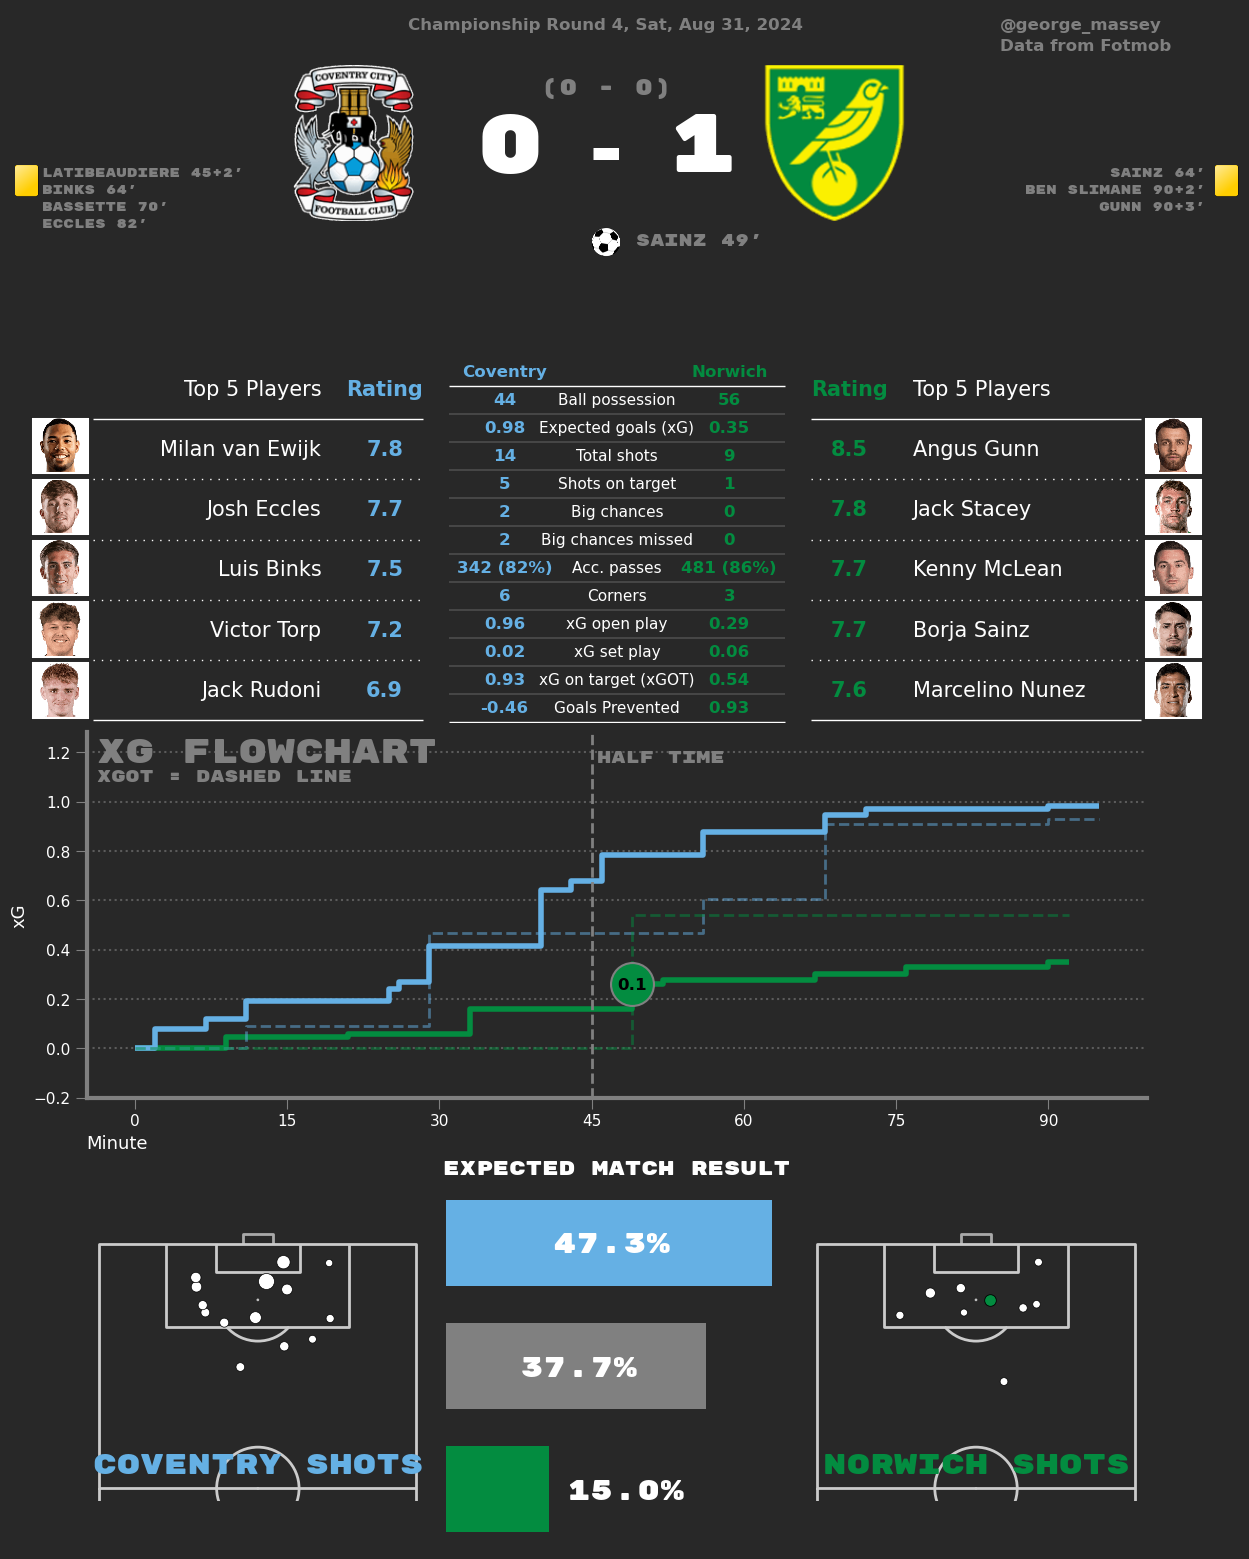

In [106]:
fig = plt.figure(figsize=(12, 12), constrained_layout=True, facecolor='#282828')
gs = fig.add_gridspec(3, 3)

# SHOTMAPS
# AWAY
ax3 = fig.add_subplot(gs[2, 2])
pitch_home = VerticalPitch(half=True,
                      #pad_bottom=0.5,
                      pitch_type = 'opta',  # pitch extends slightly below halfway line
                      goal_type='box',
                      goal_alpha=0.8,
                      pitch_color='#282828')  # control the goal transparency

pitch_home.draw(ax=ax3)

sc1 = pitch_home.scatter(df_away_non_goals.x, df_away_non_goals.y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_away_non_goals.expectedGoals * 500 + 20),
                    edgecolors='black',  # give the markers a charcoal border
                    c='white',  # no facecolor for the markers
                    #hatch='///',  
                    marker='o',
                    ax=ax3)

sc2 = pitch_home.scatter(df_away_goals.x, df_away_goals.y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_away_goals.expectedGoals * 500 + 20),
                    edgecolors='black',
                    linewidths=0.6,
                    c=a_colour,
                    #marker='D',
                    ax=ax3)

txt1 = ax3.text(x=50, y=55, s=f'{a_team} shots',
              size=20,
              fontproperties=fm_rubik.prop, color=a_colour,
              va='center', ha='center')

# HOME

ax1 = fig.add_subplot(gs[2, 0])

pitch_away = VerticalPitch(half=True,
                        #pad_bottom=0.5,
                        pitch_type = 'opta',  # pitch extends slightly below halfway line
                        goal_type='box',
                        goal_alpha=0.8,
                        pitch_color='#282828')  # control the goal transparency

pitch_away.draw(ax=ax1)

sc3 = pitch_away.scatter(df_home_non_goals.x, df_home_non_goals.y,
                    # size varies between 100 and 1900 (points squared)
                    s=(df_home_non_goals.expectedGoals * 500 + 20),
                    edgecolors='black',  # give the markers a charcoal border
                    c='white',  # no facecolor for the markers
                    marker='o',
                    ax=ax1)

sc4 = pitch_away.scatter(df_home_goals.x, df_home_goals.y,
                    s=(df_home_goals.expectedGoals * 500 + 20),
                    edgecolors='black',
                    linewidths=0.6,
                    c=h_colour,
                    #marker='D',
                    ax=ax1)

txt2 = ax1.text(x=50, y=55, s=f'{h_team} shots',
              size=20,
              fontproperties=fm_rubik.prop, color=h_colour,
              va='center', ha='center')

# XG FLOWCHART
ax = fig.add_subplot(gs[1, :])
plt.style.use('fivethirtyeight')
ax.patch.set_facecolor('#282828')

ax.grid(
    axis = "y",
    visible = True, 
    lw = 1.5,
    ls = ":",
    alpha = 0.3,
    color = "lightgrey"
)

ax.grid(
    axis = "x",
    visible = False, 
)

ax.tick_params(
    color = "grey", 
    length = 8, 
    which = "major", 
    labelsize = 11,
    labelcolor = "white",
    zorder = 3
)

ax.step(x = a_min ,y = a_cumulative , where = 'post', color = a_colour ,linewidth = 4.0)
ax.step(x = h_min ,y = h_cumulative , where = 'post', color = h_colour ,linewidth = 4.0)

ax.scatter(x=x,y=y, color=h_colour, edgecolor='grey',s=955, label=h_team,linewidths=1.5, zorder = 3)
ax.scatter(x=x1,y=y1, color=a_colour, edgecolor='grey',s=955, label=a_team,linewidths=1.5, zorder = 3)

ax.step(x = h_min_xGOT ,y = h_cumulativeOT , where = 'post', color = h_colour ,linewidth = 2.0, linestyle='dashed', alpha=0.5)
ax.step(x = a_min_xGOT ,y = a_cumulativeOT , where = 'post', color = a_colour ,linewidth = 2.0, linestyle='dashed', alpha=0.5)

max_xG = max(max(a_cumulative),max(h_cumulative))
max_xGOT = max(max(a_cumulativeOT),max(h_cumulativeOT))
max_value = max(max_xG,max_xGOT)

for i in range(len(x)):
    plt.annotate(y_plot[i], (x[i], y[i]),c='black',size=12,ha='center',va='center',fontweight='bold', zorder = 5)
# Away team
for i in range(len(x1)):
    plt.annotate(y1_plot[i], (x1[i], y1[i]),c='black',size=12,ha='center',va='center',fontweight='bold', zorder = 5)

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")
if df['period'].nunique() > 2:
    plt.xticks([0,15,30,45,60+first_half_added_time,75+first_half_added_time,90+first_half_added_time,105+first_half_added_time+second_half_added_time,120+first_half_added_time+second_half_added_time+first_half_extra_time]
               ,['0','15','30','45','60','75','90','105','120']) # fix this 
else:
    plt.xticks([0,15,30,45,60+first_half_added_time,75+first_half_added_time,90+first_half_added_time], ['0','15','30','45','60','75','90'])
ax.annotate('XG Flowchart', xy=(0, 0), xytext=(0.01, 0.95), xycoords='axes fraction', fontproperties=fm_rubik.prop, fontsize=24, color='grey', ha='left', va='center')
ax.annotate('XGOT = Dashed Line', xy=(0, 0), xytext=(0.01, 0.88), xycoords='axes fraction', fontproperties=fm_rubik.prop, fontsize=12, color='grey', ha='left', va='center')
plt.xlabel('Minute',color='white',fontsize=13,loc='left')
plt.ylabel('xG',color='white',fontsize=13)
plt.axvline(x=45+first_half_added_time, color='grey', linestyle='--', linewidth=2, zorder = 2)
plt.annotate('Half Time', xy=(45.5+first_half_added_time, max_value+0.2), fontproperties=fm_rubik.prop, fontsize=12, color='grey', ha='left', va='center')
if df['period'].nunique() > 2:
    plt.axvline(x=90+first_half_added_time+second_half_added_time, color='grey', linestyle='--', linewidth=2, zorder = 2)
    plt.annotate('Extra Time', xy=(90.5+first_half_added_time+second_half_added_time, max_value+0.2), fontproperties=fm_rubik.prop, fontsize=12, color='grey', ha='left', va='center')
plt.ylim(-0.2,max_value+0.3)
# STATS TABLE
ax2 = fig.add_subplot(gs[0, 1])


ax2.set_facecolor(bg_colour)

table = Table(
    df_top_stats_plot,
    column_definitions=col_defs,
    index_col=h_team,
    #row_dividers=True,
    #row_divider_kw={"linewidth" : 1, "linestyle" : (0, (1,5))},
    footer_divider=True,
    textprops={"fontsize" : 12},
    ax=ax2,
    #even_row_color=row_colors["even"],
    #odd_row_color=row_colors["odd"],
)

# EXPECTED RESULT
ax4 = fig.add_subplot(gs[2, 1])
bar_width = 0.7
bar_positions = [0, 1, 2]
ax4.set_facecolor('#282828')

bars = ax4.barh([2, 1, 0], [home_wins_perc, draws_perc, away_wins_perc], bar_width, align='center', color=[h_colour, 'grey', a_colour])

for bar in bars:
    bar_value = bar.get_width()
    if bar_value > 25:  # Adjust this threshold as needed
        ax4.annotate(f'{bar_value:.1f}%', xy=(bar_value/2, bar.get_y() + bar_width/2), xytext=(2, 0), textcoords='offset points', ha='center', va='center', fontweight='bold', color='white', fontsize=20,fontproperties=fm_rubik.prop)
    else:
        label_x = bar_value + 2
        label_y = bar.get_y() + bar_width/2
        ax4.annotate(f'{bar_value:.1f}%', xy=(label_x, label_y), xytext=(2, 0), textcoords='offset points', ha='left', va='center', fontweight='bold', color='white', fontsize=20,fontproperties=fm_rubik.prop)

# Set the tick labels
ax4.set_yticks(bar_positions)
ax4.set_yticklabels(['Away Win', 'Draw', 'Home Win'])

# Set the axis labels and title
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_title('Expected Match Result', color='white', fontsize=10, fontweight='bold', fontproperties=fm_rubik.prop)
ax4.spines[["top", "right","left", "bottom"]].set_visible(False)
ax4.tick_params(axis='both', which='both', length=0)
ax4.grid(visible=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

# HOME TOP 5
ax5 = fig.add_subplot(gs[0, 0])
ax5.set_facecolor(bg_colour)

table = Table(
    home_played_top_plot,
    column_definitions=home_col_defs,
    index_col="name",
    row_dividers=True,
    row_divider_kw={"linewidth" : 1, "linestyle" : (0, (1,5))},
    footer_divider=True,
    textprops={"fontsize" : 15},
    ax=ax5,
)

from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for i in range(0,5):
    img = io.imread(home_played_top['imageUrl'][i])
    img_offset = OffsetImage(img, zoom=0.2)
    img_box = AnnotationBbox(img_offset, (0, 0.83-(i/6)), xycoords='axes fraction', box_alignment=(1.0, 1.0), boxcoords="offset pixels", frameon=True, pad=0.1)
    ax5 = plt.gca()
    ax5.add_artist(img_box)

# AWAY TOP 5
# HOME TOP 5
ax6 = fig.add_subplot(gs[0, 2])
ax6.set_facecolor(bg_colour)

table = Table(
    away_played_top_plot,
    column_definitions=away_col_defs,
    index_col="rating",
    row_dividers=True,
    row_divider_kw={"linewidth" : 1, "linestyle" : (0, (1,5))},
    footer_divider=True,
    textprops={"fontsize" : 15},
    ax=ax6,
)

for i in range(0,5):
    img = io.imread(away_played_top['imageUrl'][i])
    img_offset = OffsetImage(img, zoom=0.2)
    img_box = AnnotationBbox(img_offset, (1.15, 0.83-(i/6)), xycoords='axes fraction', box_alignment=(1.0, 1.0), boxcoords="offset pixels", frameon=True, pad=0.1)
    ax6 = plt.gca()
    ax6.add_artist(img_box)

# HEADER
# Open the images
#home_logo = Image.open(h_badge)
#away_logo = Image.open(a_badge)

home_logo = io.imread(data['header']['teams'][0]['imageUrl'])
away_logo = io.imread(data['header']['teams'][1]['imageUrl'])

#target_size = (800, 800)  # Adjust the size as needed
#home_logo = home_logo.resize(target_size)
#away_logo = away_logo.resize(target_size)

#img_offset = OffsetImage(img, zoom=0.4)
#img_box = AnnotationBbox(img_offset, (0, 1), xycoords='axes fraction', box_alignment=(1.0, 1.0), boxcoords="offset pixels", frameon=False, pad=0.1)
#ax10 = plt.gca()
#ax10.add_artist(img_box)
#ax10.axis('off')
# Convert the resized images back to a format that can be plotted

home_logo_ax = OffsetImage(home_logo)
away_logo_ax = OffsetImage(away_logo)
home_logo_ax = fig.add_axes([0.2, 1.11, 0.18, 0.13], zorder=1)
home_logo_ax.imshow(home_logo)
home_logo_ax.axis("off")
fig_text(0.42, 1.2, f'{h_goals.astype(int)}', color='white', fontsize=60, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)

away_logo_ax = fig.add_axes([0.6, 1.11, 0.18, 0.13], zorder=1)
away_logo_ax.imshow(away_logo)
away_logo_ax.axis("off")
fig_text(0.58, 1.2, f'{a_goals.astype(int)}', color='white', fontsize=60, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
fig_text(0.5, 1.2, '-', color='white', fontsize=60, ha='center', fontweight='bold')
fig_text(0.5, 1.23, f'({first_half_home_goals} - {first_half_away_goals})', color='grey', fontsize=16, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
fig_text(0.9, 1.28, '@george_massey\nData from Fotmob', color='grey', fontsize=12, ha='center', fontweight='bold')
fig_text(0.5,1.28, f'{match_type} {match_round}, {match_date}',color='grey', fontsize=12, ha='center', fontweight='bold')
#fig_text(0.485, 1.15, pen, color='white', fontsize=14, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
if periods == 5:
    fig_text(0.5, 1.13, 'AET and Pens:', color='white', fontsize=12, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
    fig_text(0.5, 1.10, pen, color='white', fontsize=20, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
if periods == 4:
    fig_text(0.5, 1.13, 'After Extra Time', color='white', fontsize=12, ha='center', fontweight='bold',fontproperties=fm_rubik.prop)
for i in range(len(df_home_goals)):
    if periods == 5:
        if df_home_goals['minAdded'][i] > 0:
            if df_home_goals['situation'][i] == 'Penalty':
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'(Pen)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            elif df_home_goals['isOwnGoal'][i] == True:
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'(OG)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
        else:
            if df_home_goals['situation'][i] == 'Penalty':
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'(Pen)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            elif df_home_goals['isOwnGoal'][i] == True:
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'(OG)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.48, 1.06-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
    else:
        if df_home_goals['minAdded'][i] > 0:
            if df_home_goals['situation'][i] == 'Penalty':
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'(Pen)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            elif df_home_goals['isOwnGoal'][i] == True:
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'(OG)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}+{df_home_goals["minAdded"][i]}\'', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
        else:
            if df_home_goals['situation'][i] == 'Penalty':
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'(Pen)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            elif df_home_goals['isOwnGoal'][i] == True:
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'(OG)', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.48, 1.1-(i/70), f'{df_home_goals["playerName"][i]} {df_home_goals["min"][i]}\'', color='grey', fontsize=12, ha='right',fontproperties=fm_rubik.prop)

for i in range(len(df_away_goals)):
    if periods == 5:
        if df_away_goals['minAdded'][i] > 0:
            if df_away_goals['situation'][i] == 'Penalty':
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'(Pen)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            elif df_away_goals['isOwnGoal'][i] == True:
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'(OG)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
        else:
            if df_away_goals['situation'][i] == 'Penalty':
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'(Pen)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            elif df_away_goals['isOwnGoal'][i] == True:
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'(OG)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.525, 1.06-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
    else:
        if df_away_goals['minAdded'][i] > 0:
            if df_away_goals['situation'][i] == 'Penalty':
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'(Pen)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            elif df_away_goals['isOwnGoal'][i] == True:
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'(OG)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}+{df_away_goals["minAdded"][i]}\'', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
        else:
            if df_away_goals['situation'][i] == 'Penalty':
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'(Pen)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            elif df_away_goals['isOwnGoal'][i] == True:
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'(OG)', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
            else:
                fig_text(0.525, 1.1-(i/70), f'{df_away_goals["playerName"][i]} {df_away_goals["min"][i]}\'', color='grey', fontsize=12, ha='left',fontproperties=fm_rubik.prop)
for i in range(len(df_home_yellows)):
    fig_text(0.03, 1.155-(i/70), f'{df_home_yellows["player"][i]} {df_home_yellows["timeStr"][i]}\'', color='grey', fontsize=9, ha='left',fontproperties=fm_rubik.prop)
for i in range(len(df_away_yellows)):
    fig_text(1, 1.155-(i/70), f'{df_away_yellows["player"][i]} {df_away_yellows["timeStr"][i]}\'', color='grey', fontsize=9, ha='right',fontproperties=fm_rubik.prop)
for i in range(len(df_home_reds)):
    fig_text(0.03, 1.225-(i/70), f'{df_home_reds["player"][i]} {df_home_reds["timeStr"][i]}\'', color='grey', fontsize=9, ha='left',fontproperties=fm_rubik.prop)
for i in range(len(df_away_reds)):
    fig_text(1, 1.225-(i/70), f'{df_away_reds["player"][i]} {df_away_reds["timeStr"][i]}\'', color='grey', fontsize=9, ha='right',fontproperties=fm_rubik.prop)
red_card_path = r"C:\Users\George\Documents\Football Analytics\Images\red.png"
yellow_card_path =r"C:\Users\George\Documents\Football Analytics\Images\yellow.png"
red_card_image = Image.open(red_card_path)
yellow_card_image = Image.open(yellow_card_path)

if len(df_home_reds) > 0:
    red_ax1 = fig.add_axes([0, 1.2, 0.035, 0.027], zorder=1)
    red_ax1.imshow(red_card_image)
    red_ax1.axis("off")

if len(df_away_reds) > 0:
    red_ax2 = fig.add_axes([1, 1.2, 0.035, 0.027], zorder=1)
    red_ax2.imshow(red_card_image)
    red_ax2.axis("off")

if len(df_home_yellows) > 0:
    yellow_ax1 = fig.add_axes([0, 1.13, 0.035, 0.027], zorder=1)
    yellow_ax1.imshow(yellow_card_image)
    yellow_ax1.axis("off")

if len(df_away_yellows) > 0:
    yellow_ax2 = fig.add_axes([1, 1.13, 0.035, 0.027], zorder=1)
    yellow_ax2.imshow(yellow_card_image)
    yellow_ax2.axis("off")

ball_path = r"C:\Users\George\Documents\Football Analytics\Images\ball.png"
ball_image = Image.open(ball_path)

if len(df_home_goals) > 0 or len(df_away_goals) > 0:
    if periods == 5:
        ball_ax = fig.add_axes([0.485, 1.04, 0.03, 0.025], zorder=1)
    else:
        ball_ax = fig.add_axes([0.485, 1.08, 0.03, 0.025], zorder=1)
    ball_ax.imshow(ball_image)
    ball_ax.axis("off")

In [107]:
fig.savefig(
    f"C:/Users/George/Documents/Football Analytics/Visuals/{h_team} vs {a_team}.png",
    facecolor=ax.get_facecolor(),
    dpi=200,
    bbox_inches="tight"
)